In [15]:
import os
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report


In [16]:
# Dataset directory
sdir = r"C:\Users\alfin\Skripsi\Dataset\LBP"

# Prepare file paths and labels
filepaths = []
labels = []
classlist = os.listdir(sdir)
for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

# Create dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  C:\Users\alfin\Skripsi\Dataset\LBP\001\001_F_L...    001
1  C:\Users\alfin\Skripsi\Dataset\LBP\001\001_F_L...    001
2  C:\Users\alfin\Skripsi\Dataset\LBP\001\001_F_L...    001
3  C:\Users\alfin\Skripsi\Dataset\LBP\001\001_F_L...    001
4  C:\Users\alfin\Skripsi\Dataset\LBP\001\001_F_L...    001
labels
050    40
042    40
025    40
023    40
022    40
033    40
035    40
019    40
037    40
017    40
016    40
002    40
043    40
044    40
010    40
045    40
046    40
007    40
006    40
047    40
048    40
049    40
027    39
038    37
028    37
014    37
001    36
005    35
020    34
003    33
008    33
034    32
009    31
024    30
015    29
032    28
039    27
030    27
012    26
036    26
026    26
029    25
011    25
031    25
018    24
040    23
041    22
013    22
004    21
021    12
Name: count, dtype: int64


In [17]:
# Split data into training, validation, and test sets using stratified sampling
train_split = 0.8
test_split = 0.1

# First split to get train and temp (which will be split into valid and test)
train_df, temp_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123, stratify=df['labels'])

# Now split temp into valid and test
valid_split = test_split / (1 - train_split)
valid_df, test_df = train_test_split(temp_df, train_size=valid_split, shuffle=True, random_state=123, stratify=temp_df['labels'])

print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1345   test_df length:  169   valid_df length:  168


In [4]:
batch = 32

# Calculate test batch size
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]  
test_steps = int(length/test_batch_size)
print('test batch size: ', test_batch_size, '  test steps: ', test_steps)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical', batch_size=batch)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical', batch_size=batch)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical', batch_size=batch, shuffle=False)

classes = list(train_generator.class_indices.keys())
print(classes)
class_count = len(classes)

test batch size:  13   test steps:  13
Found 1345 validated image filenames belonging to 50 classes.
Found 168 validated image filenames belonging to 50 classes.
Found 169 validated image filenames belonging to 50 classes.
['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050']


In [5]:
# Load VGG16 model with pre-trained weights, excluding the top layers
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Build the model
model_name = 'PalmPrint'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='softmax')  # Ensure this matches the number of classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Perform a forward pass to define the model's input
dummy_input = np.zeros((1, 224, 224, 3))
model.predict(dummy_input)

# Print the model summary
model.summary()


Building model with <tensorflow.python.keras.engine.functional.Functional object at 0x000001364075E640>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 32)          147488    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                14450     
Total params: 14,8

In [9]:
epochs =100

history=model.fit(x=train_generator, epochs=epochs, validation_data=valid_generator, steps_per_epoch=21)

Epoch 1/100
21/21 [==============================] - 236s 11s/step - loss: 3.9452 - accuracy: 0.0289 - val_loss: 3.8259 - val_accuracy: 0.0774
Epoch 2/100
21/21 [==============================] - 224s 11s/step - loss: 3.7887 - accuracy: 0.0765 - val_loss: 3.6793 - val_accuracy: 0.0952
Epoch 3/100
21/21 [==============================] - 229s 11s/step - loss: 3.6698 - accuracy: 0.0960 - val_loss: 3.5223 - val_accuracy: 0.1905
Epoch 4/100
21/21 [==============================] - 233s 11s/step - loss: 3.5057 - accuracy: 0.1280 - val_loss: 3.3155 - val_accuracy: 0.3155
Epoch 5/100
21/21 [==============================] - 227s 11s/step - loss: 3.3188 - accuracy: 0.1866 - val_loss: 3.0859 - val_accuracy: 0.3512
Epoch 6/100
21/21 [==============================] - 226s 11s/step - loss: 3.0914 - accuracy: 0.2217 - val_loss: 2.8749 - val_accuracy: 0.3929
Epoch 7/100
21/21 [==============================] - 228s 11s/step - loss: 2.9232 - accuracy: 0.2490 - val_loss: 2.6506 - val_accuracy: 0.5119

In [10]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [12]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

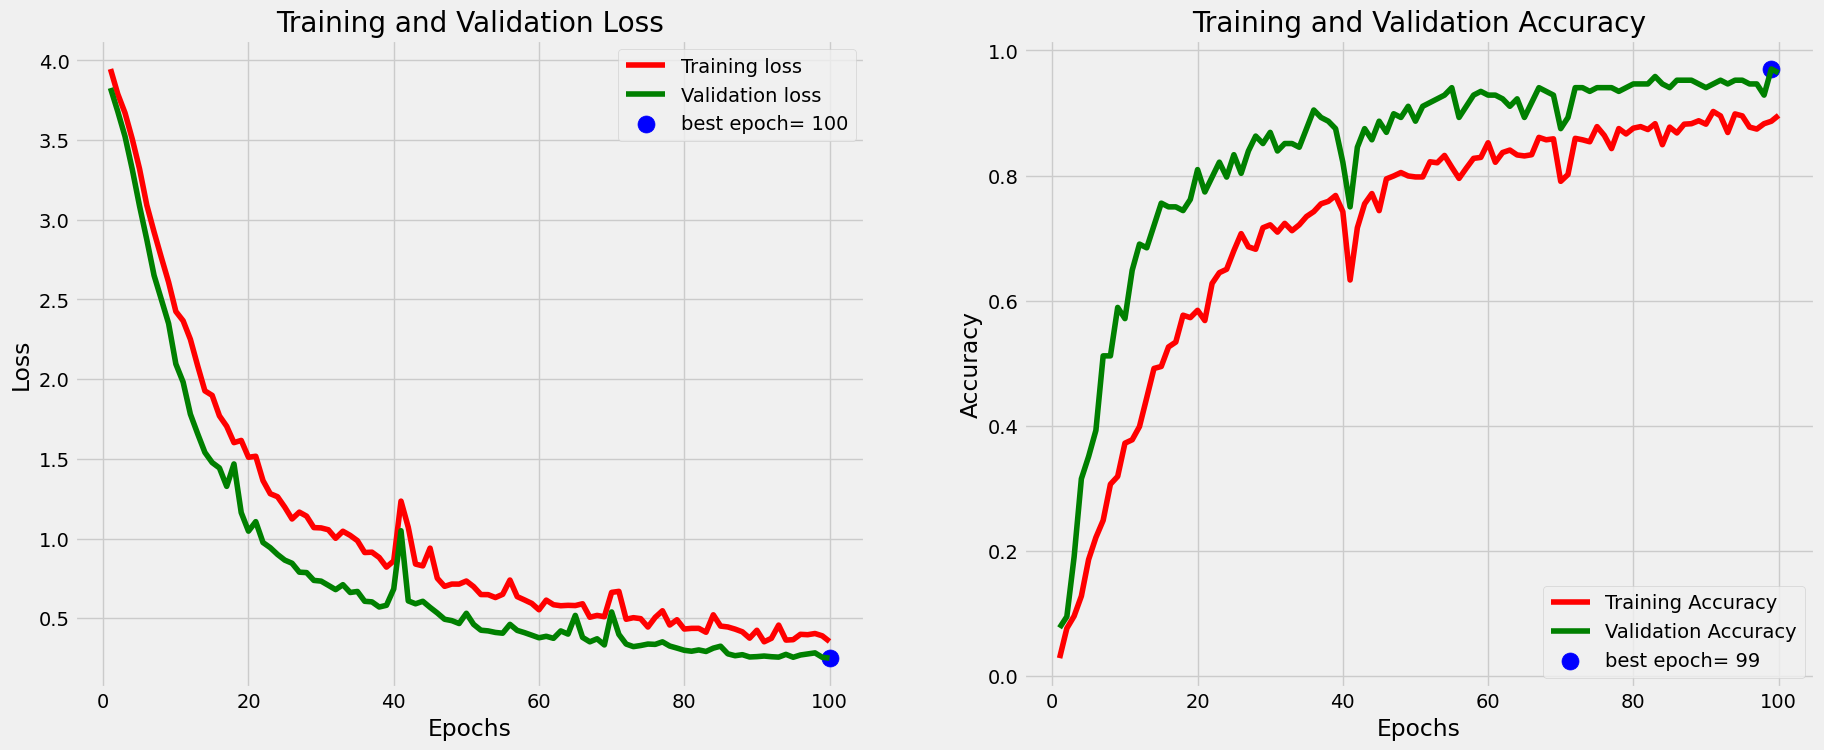

 3/13 [=====>........................] - 18s 6s/step - loss: 0.2048 - accuracy: 0.9645
accuracy on the test set is 96.45 %



In [13]:
tr_plot(history,0)
save_dir=r"C:\Users\alfin\web"
subject='Identification'
acc=model.evaluate( test_generator, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

Classification Report:
----------------------
               precision    recall  f1-score   support

         001       1.00      1.00      1.00         4
         002       1.00      1.00      1.00         4
         003       1.00      1.00      1.00         4
         004       1.00      1.00      1.00         2
         005       1.00      1.00      1.00         4
         006       1.00      1.00      1.00         4
         007       1.00      1.00      1.00         4
         008       1.00      0.75      0.86         4
         009       0.67      0.67      0.67         3
         010       1.00      1.00      1.00         4
         011       1.00      1.00      1.00         3
         012       1.00      1.00      1.00         2
         013       1.00      0.50      0.67         2
         014       1.00      1.00      1.00         4
         015       1.00      1.00      1.00         3
         016       1.00      1.00      1.00         4
         017       1.00      1.00 

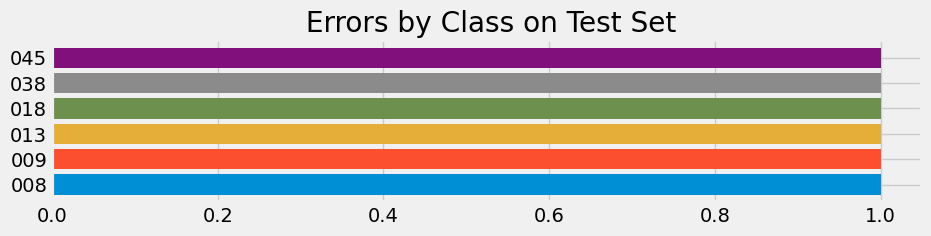

In [14]:
print_code=0
preds=model.predict(test_generator) 
print_info( test_generator, preds, print_code, save_dir, subject )  